# Prophet

In [93]:
# Suppress warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [94]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet

## 1. Read in dataset

In [ ]:
data = pd.read_csv('Timeseries Analysis/AAPL.csv')

In [96]:
import datetime

def str_to_datetime(s):
    # If already a datetime or date, return as-is
    if isinstance(s, (datetime.datetime, datetime.date)):
        return s
    
    # Otherwise, parse from string
    date_part = s.split(' ')[0]
    year, month, day = map(int, date_part.split('-'))
    return datetime.datetime(year=year, month=month, day=day)
data=data[['date','close']]
data.rename(columns={'close':'stock_price'},inplace=True)
data['date']=data['date'].apply(str_to_datetime)
data['date']
data.index = data.pop('date')  # Set datetime index
data.head()

,stock_price
date,
2015-05-27,132.045
2015-05-28,131.780
2015-05-29,130.280
2015-06-01,130.535
2015-06-02,129.960


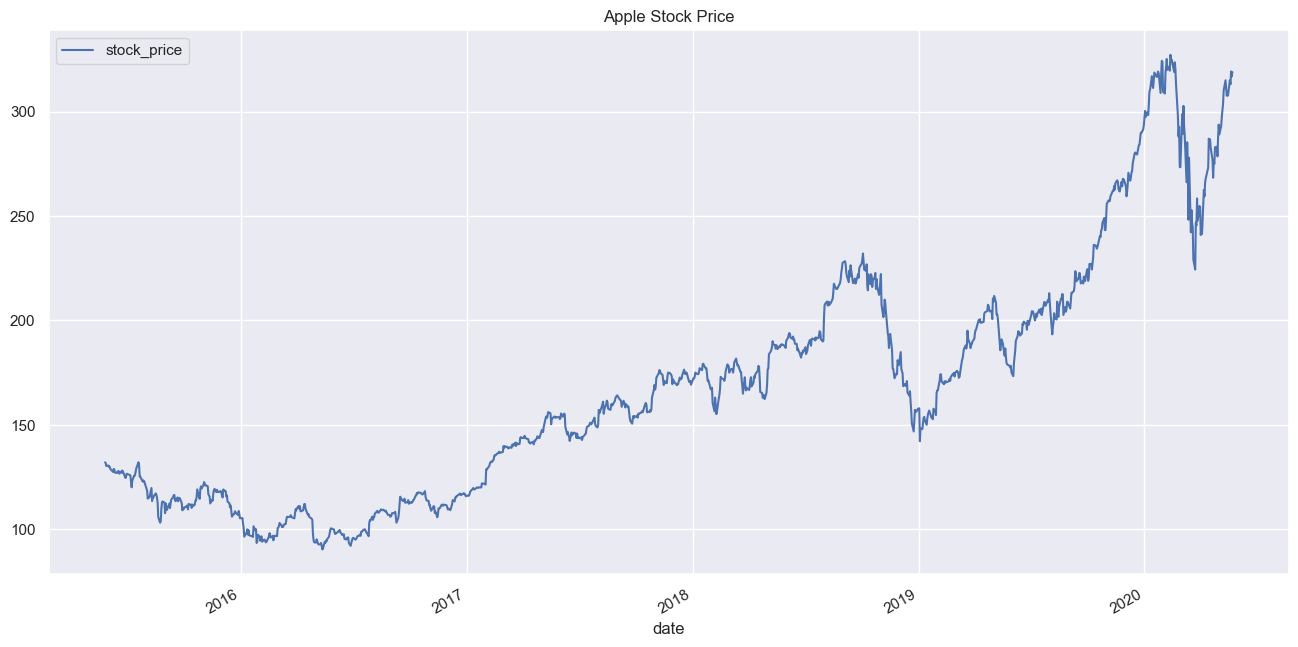

In [97]:
data.plot(figsize=(16, 8), title='Apple Stock Price')
plt.show()

## 2. Implement Prophet to predict monthly passengers

In [100]:
# Create train dataset
TRAIN_RANGE = (datetime.datetime(2015, 5, 27), datetime.datetime(2019, 5, 22))
TEST_RANGE = (datetime.datetime(2019, 5, 23), datetime.datetime(2020, 5, 22))

train_df = pd.DataFrame({
    'ds': data[:TRAIN_RANGE[-1]].index, 
    'y': data[:TRAIN_RANGE[-1]]['stock_price'].values})

In [101]:
# Fit prophet model
m = Prophet()
m.fit(train_df)

16:33:01 - cmdstanpy - INFO - Chain [1] start processing
16:33:01 - cmdstanpy - INFO - Chain [1] done processing


In [102]:
# Predict
future = pd.DataFrame({'ds': data.index})
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1253,2020-05-18,169.817314,147.769860,191.692458
1254,2020-05-19,170.473343,148.458386,193.338954
1255,2020-05-20,170.650258,149.068887,193.550976
1256,2020-05-21,170.406900,150.787680,193.668170
1257,2020-05-22,170.141109,147.863438,192.853590


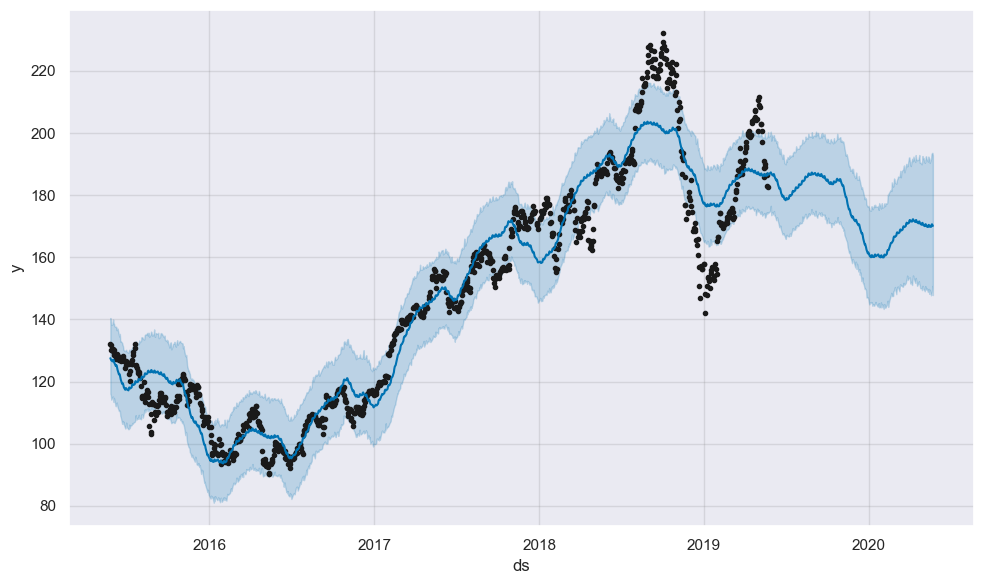

In [103]:
# Prediction result
fig1 = m.plot(forecast)
plt.show()

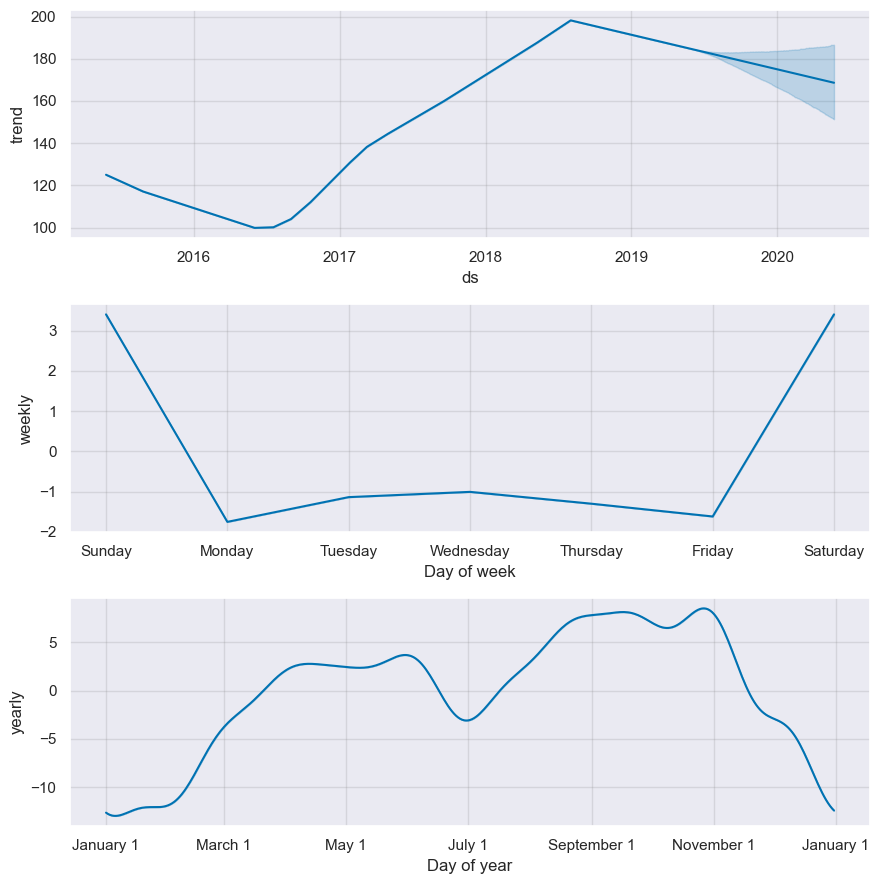

In [104]:
# Plot trend and yearly
fig2 = m.plot_components(forecast)
plt.show()

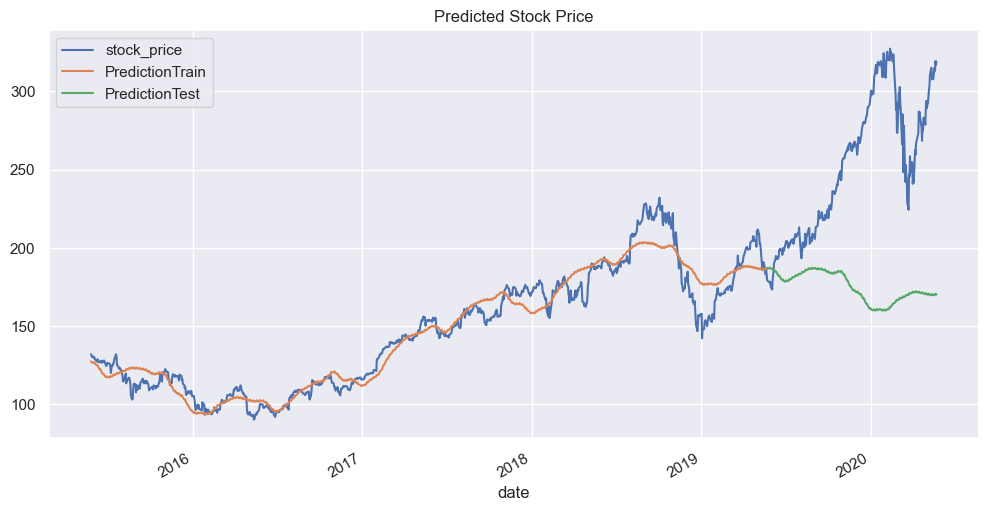

train rmse: 9.571182, mae: 7.227594
test rmse: 91.890073, mae: 76.712816


In [105]:
def evaluate_model(data, forecast):
    """Evaluate trained model by rmse (root mean squared error) and mae (mean absolute error)'"""
    
    pred_df = data.copy()
    pred_train = forecast[forecast['ds'] <= TRAIN_RANGE[-1]]['yhat'].values
    pred_test = forecast[forecast['ds'] >= TEST_RANGE[0]]['yhat'].values
    
    pred_df.loc[:TRAIN_RANGE[-1], 'PredictionTrain'] = pred_train
    pred_df.loc[TEST_RANGE[0]:, 'PredictionTest'] = pred_test
    
    pred_df[['stock_price', 'PredictionTrain', 'PredictionTest']].plot(figsize=(12, 6), title='Predicted Stock Price')
    plt.show()
    # Evaluate prediction scores of model.
    y_train = pred_df[:TRAIN_RANGE[-1]]['stock_price']
    y_test = pred_df[TEST_RANGE[0]:]['stock_price']
    
    for y, pred, mode in zip([y_train, y_test], [pred_train, pred_test], ['train', 'test']):
        rmse = np.sqrt(mean_squared_error(y, pred))
        mae = mean_absolute_error(y, pred)
        print(f'{mode} rmse: {rmse:.06f}, mae: {mae:.06f}')

evaluate_model(data, forecast)